<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 5

## Help Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.



---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import patsy

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import (precision_recall_curve, average_precision_score, f1_score)
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline

# this line makes plots prettier on mac retina screens. If you don't have one it shouldn't do anything.
%config InlineBackend.figure_format = 'retina'

In [104]:
business = pd.read_csv('/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/yelp/businesses_small_parsed.csv')
checkins = pd.read_csv('/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/yelp/checkins_small_parsed.csv')
reviews = pd.read_csv('/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/yelp/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/yelp/tips_small_nlp_parsed.csv')
users = pd.read_csv('/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/yelp/users_small_parsed.csv')

In [105]:
#Want to convert to wide format
def select_item_or_nan(x):
    x = x.iloc[0]
    if len(x) == 0:
        return np.nan
    else:
        return x

business_wide = pd.pivot_table(business, columns=['variable'], values='value',
                            index=['business_id','name','review_count','city','stars','categories'], aggfunc=select_item_or_nan,
                            fill_value=np.nan).reset_index()

In [106]:
# Number of reviews a business gets looks like it will be a strong signal for city as Vegas businesses tend to have
# more reviews. That said the std is pretty damn high. This leads me to think the tails are pretty fat. 
business_summary = business_wide.groupby(['city'])['review_count'].agg(['mean','sum','count','std']).reset_index()
business_summary

,city,mean,sum,count,std
0,Las Vegas,100.050195,257129,2570,267.581310
1,Phoenix,66.518414,93924,1412,132.949127
2,Surprise,36.636364,2821,77,42.800919
3,Waterloo,13.452055,982,73,12.426496


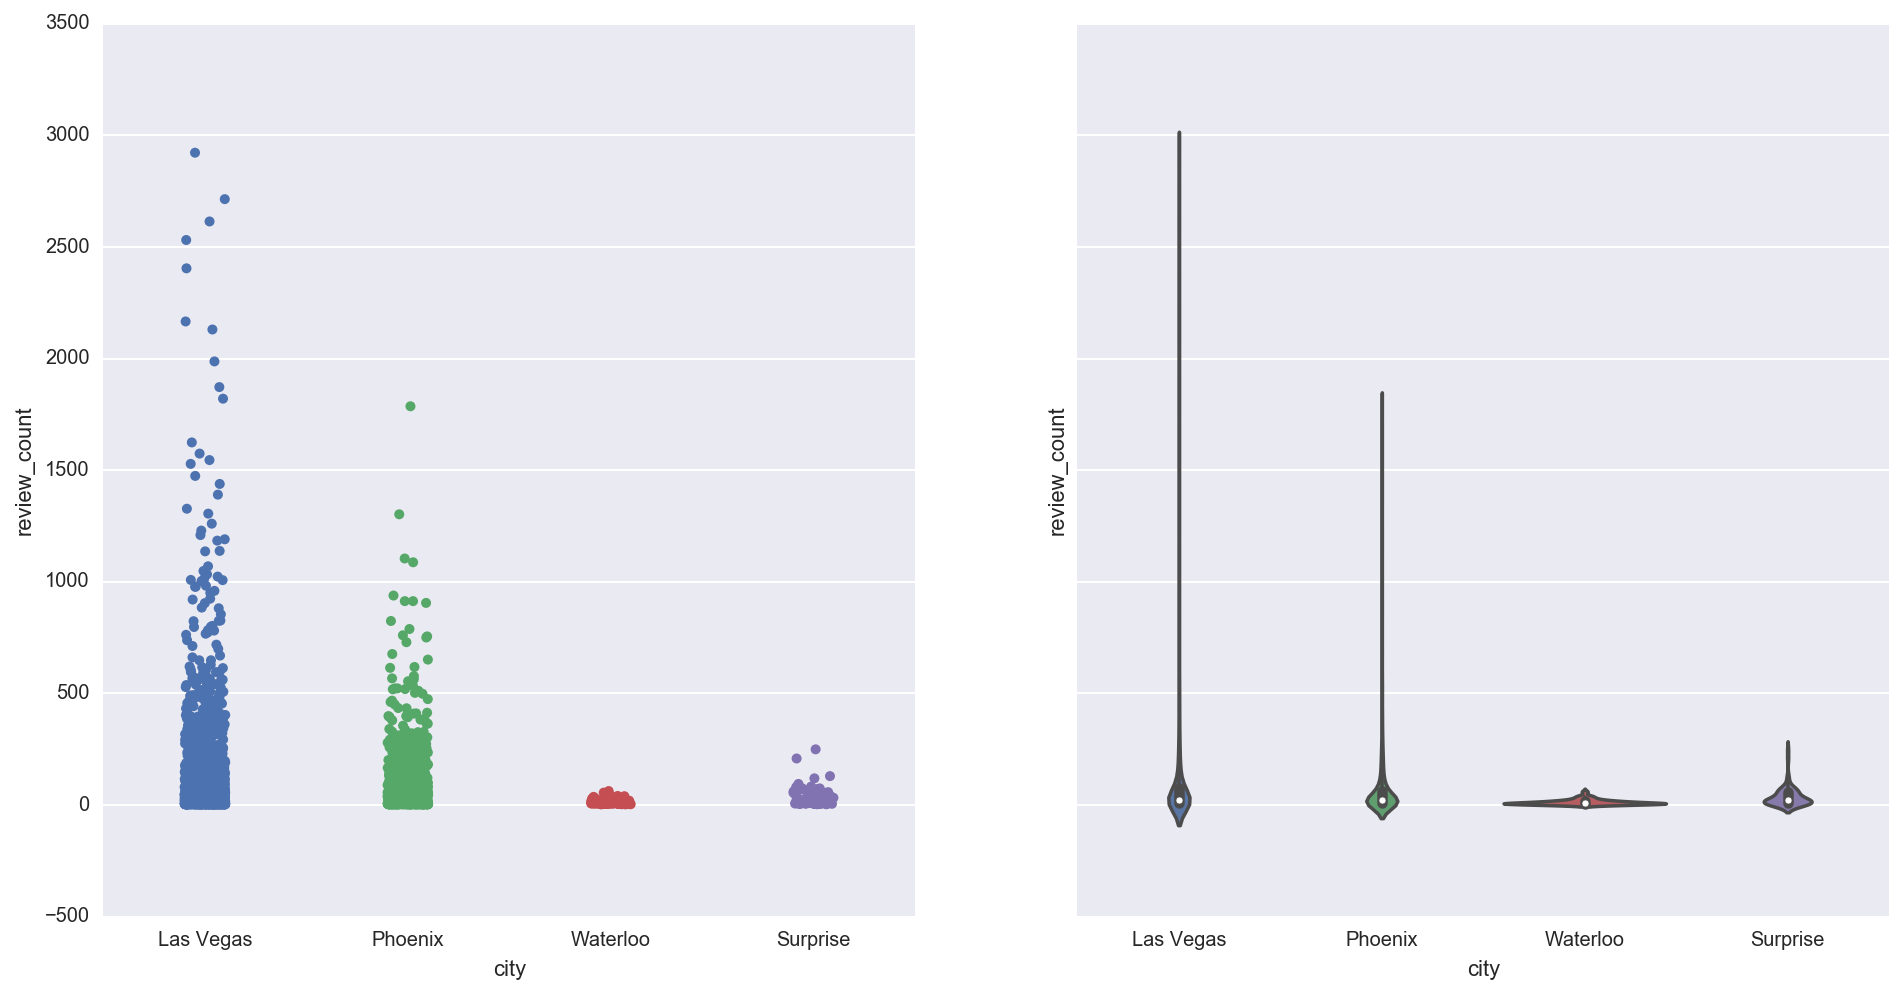

In [107]:
# call regplot on each axes
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16,8))


sns.stripplot(x="city", y="review_count", data=business_wide[business_wide.review_count<3000], jitter=True, ax=ax1)
sns.violinplot(x='city',y='review_count',data=business_wide[business_wide.review_count<3000], ax=ax2)

plt.show()

#Plotting review count by city to get idea of distribution (filtered <3k so get rid of few vegas outliers to help with 
#scale)

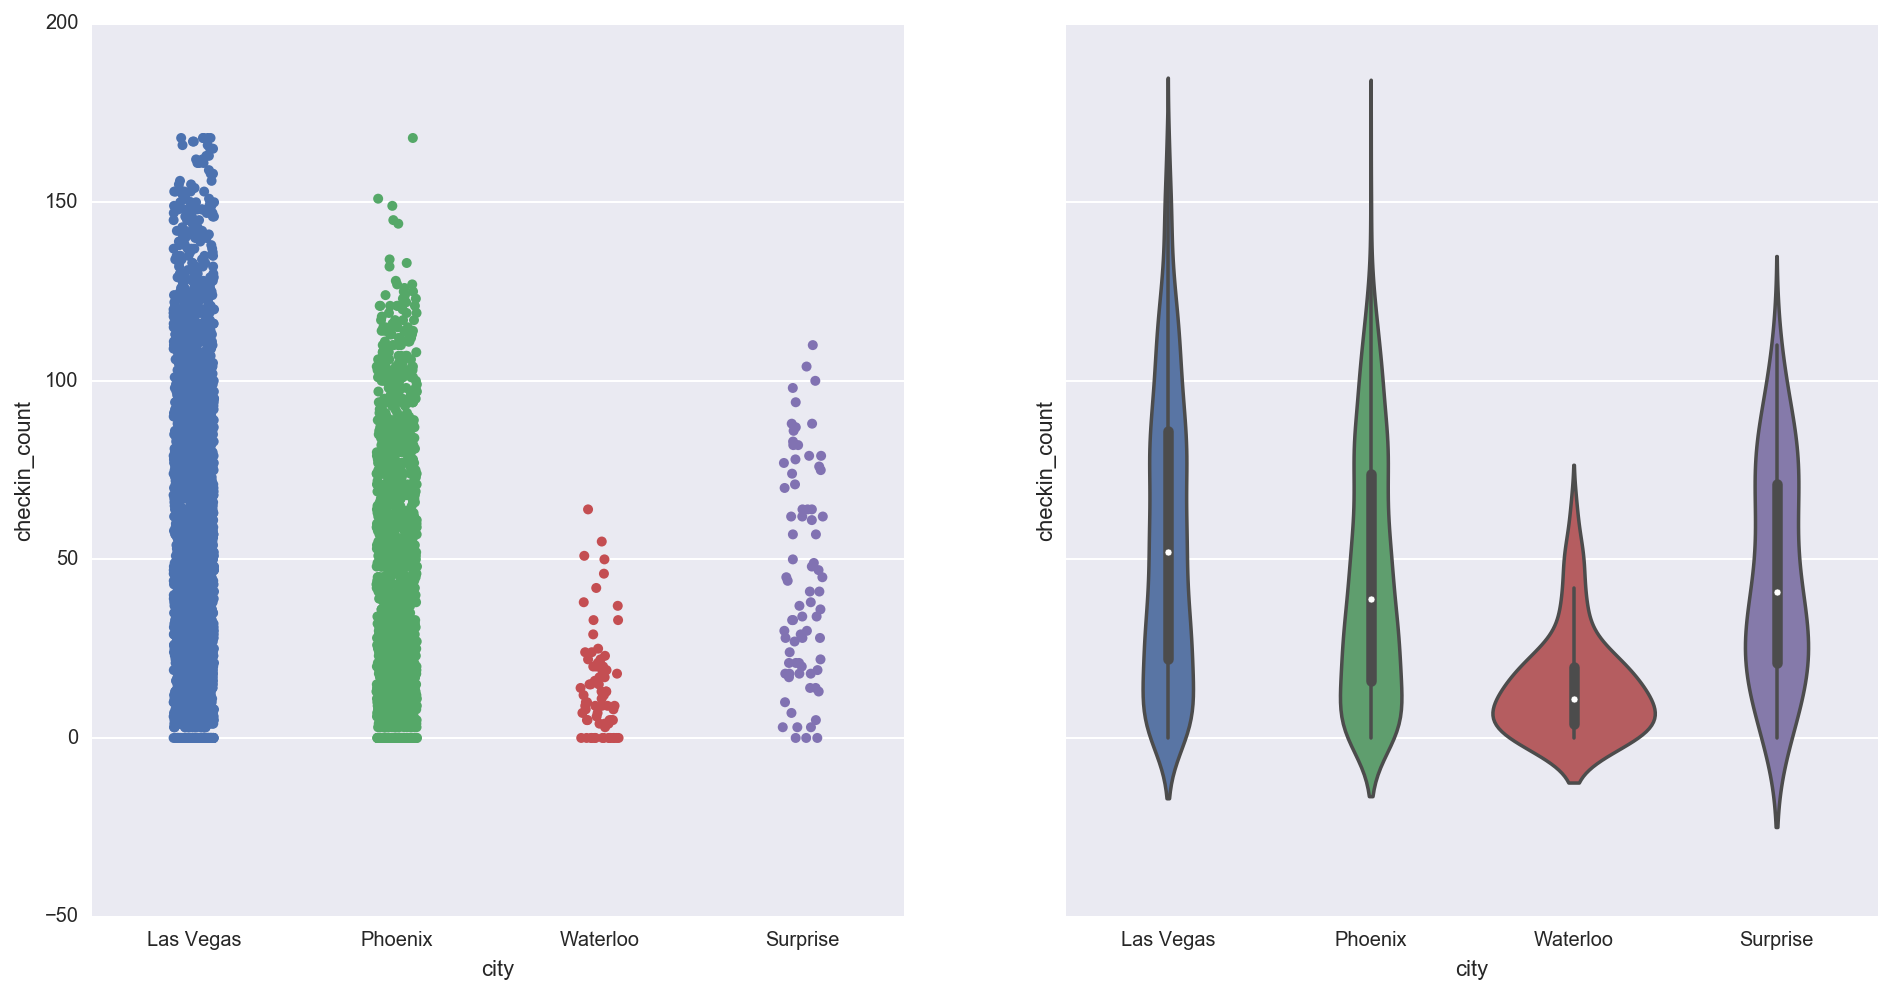

In [108]:
#Checkin looks like it can be a descent signal as well. 
business_wide[['business_id','city']].head()
check_bycity = pd.merge(business_wide[['business_id','city']], checkins, how='left',on='business_id')

check_sum = check_bycity.groupby(['business_id','city'])['value'].count().reset_index()
check_sum.rename(columns={'value':'checkin_count'},inplace=True)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16,8))

sns.stripplot(x="city", y="checkin_count", data=check_sum, jitter=True, ax=ax1)
sns.violinplot(x='city',y='checkin_count',data=check_sum, ax=ax2)

plt.show()

In [109]:
#Creating df that will merge with wide data frame to run model on. 
check_bybusiness = check_bycity.groupby(['business_id'])['value'].count().reset_index()
check_bybusiness.rename(columns={'value':'checkin_count'},inplace=True)

In [110]:
#So this was obviously overly ambitious as this would create a huge sparse matrix. Value is going to come from linking
#businesses together by being reviewed by same person so will explore only doing this for reviewers with high number of 
#reviews...
#sparse_reviews = pd.get_dummies(reviews,columns=['user_id'],sparse=True)

#reviews.head()
review_counts = reviews.groupby(['user_id'])[['business_id']].count().reset_index().sort_values(by='business_id',ascending=False)
review_counts.rename(columns={'business_id':'user_review_count'},inplace=True)

In [111]:
top_reviewers = review_counts[(review_counts['user_review_count']>25)].user_id.unique()
business_reviewers = pd.get_dummies(reviews[reviews.user_id.isin(top_reviewers)][['business_id','user_id']],columns=['user_id'],)
business_reviewers.head()
#Business_reviewers is df will merge with businesses for final model. May toggle with threshold depending on 
#model performance and scoring. May also look to transform these to be on larger scale as I'm pretty sure
#these are going to be my best features by a long shot...


,business_id,user_id_--65q1FpAL_UQtVZ2PTGew,user_id_-4ld1qpaBNLocSBe85jWnw,user_id_-9mljS0O9mwdOnGv-Oea3Q,user_id_-F32Vl8Rk4dwsmk0f2wRIw,user_id_-JLiC5WLQIu2usjYTNmS2w,user_id_-K3ZjROK0ml2P-Rk7ttHzA,user_id_-OMlS6yWkYjVldNhC31wYg,user_id_-k-juS7vkLZVqQJj2WzIRQ,user_id_-kIvLyWpY17aRa0vPp-RmA,...,user_id_ysBQMZiuZ7VSu_YAh-lE0Q,user_id_z0EwyTRBfjtIZfKr73jAHQ,user_id_zIWHwd2lpPVegydJtauKxg,user_id_zPkj64w6rvCpXsv6Ti8Tnw,user_id_zTWH9b_ItSdLOK9ypeFOIw,user_id_za-RWjEpB9W_34NW4vS7HQ,user_id_zbUpiea2aiJSKXjj2zQ5yw,user_id_zfysCL-0uQNCWdGvzZ6QWA,user_id_zo2PHkxPCVvyo9AoCwCb3g,user_id_zs_GJibScPz5Cbz1hoNanQ
1,EmzaQR5hQlF0WIl24NxAZA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,EmzaQR5hQlF0WIl24NxAZA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,SiwN7f0N4bs4ZtPc4yPgiA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,e5kc0CQ4R-PCCDgb274gSg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,e5kc0CQ4R-PCCDgb274gSg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
business_reviewers = business_reviewers.fillna(value=0)

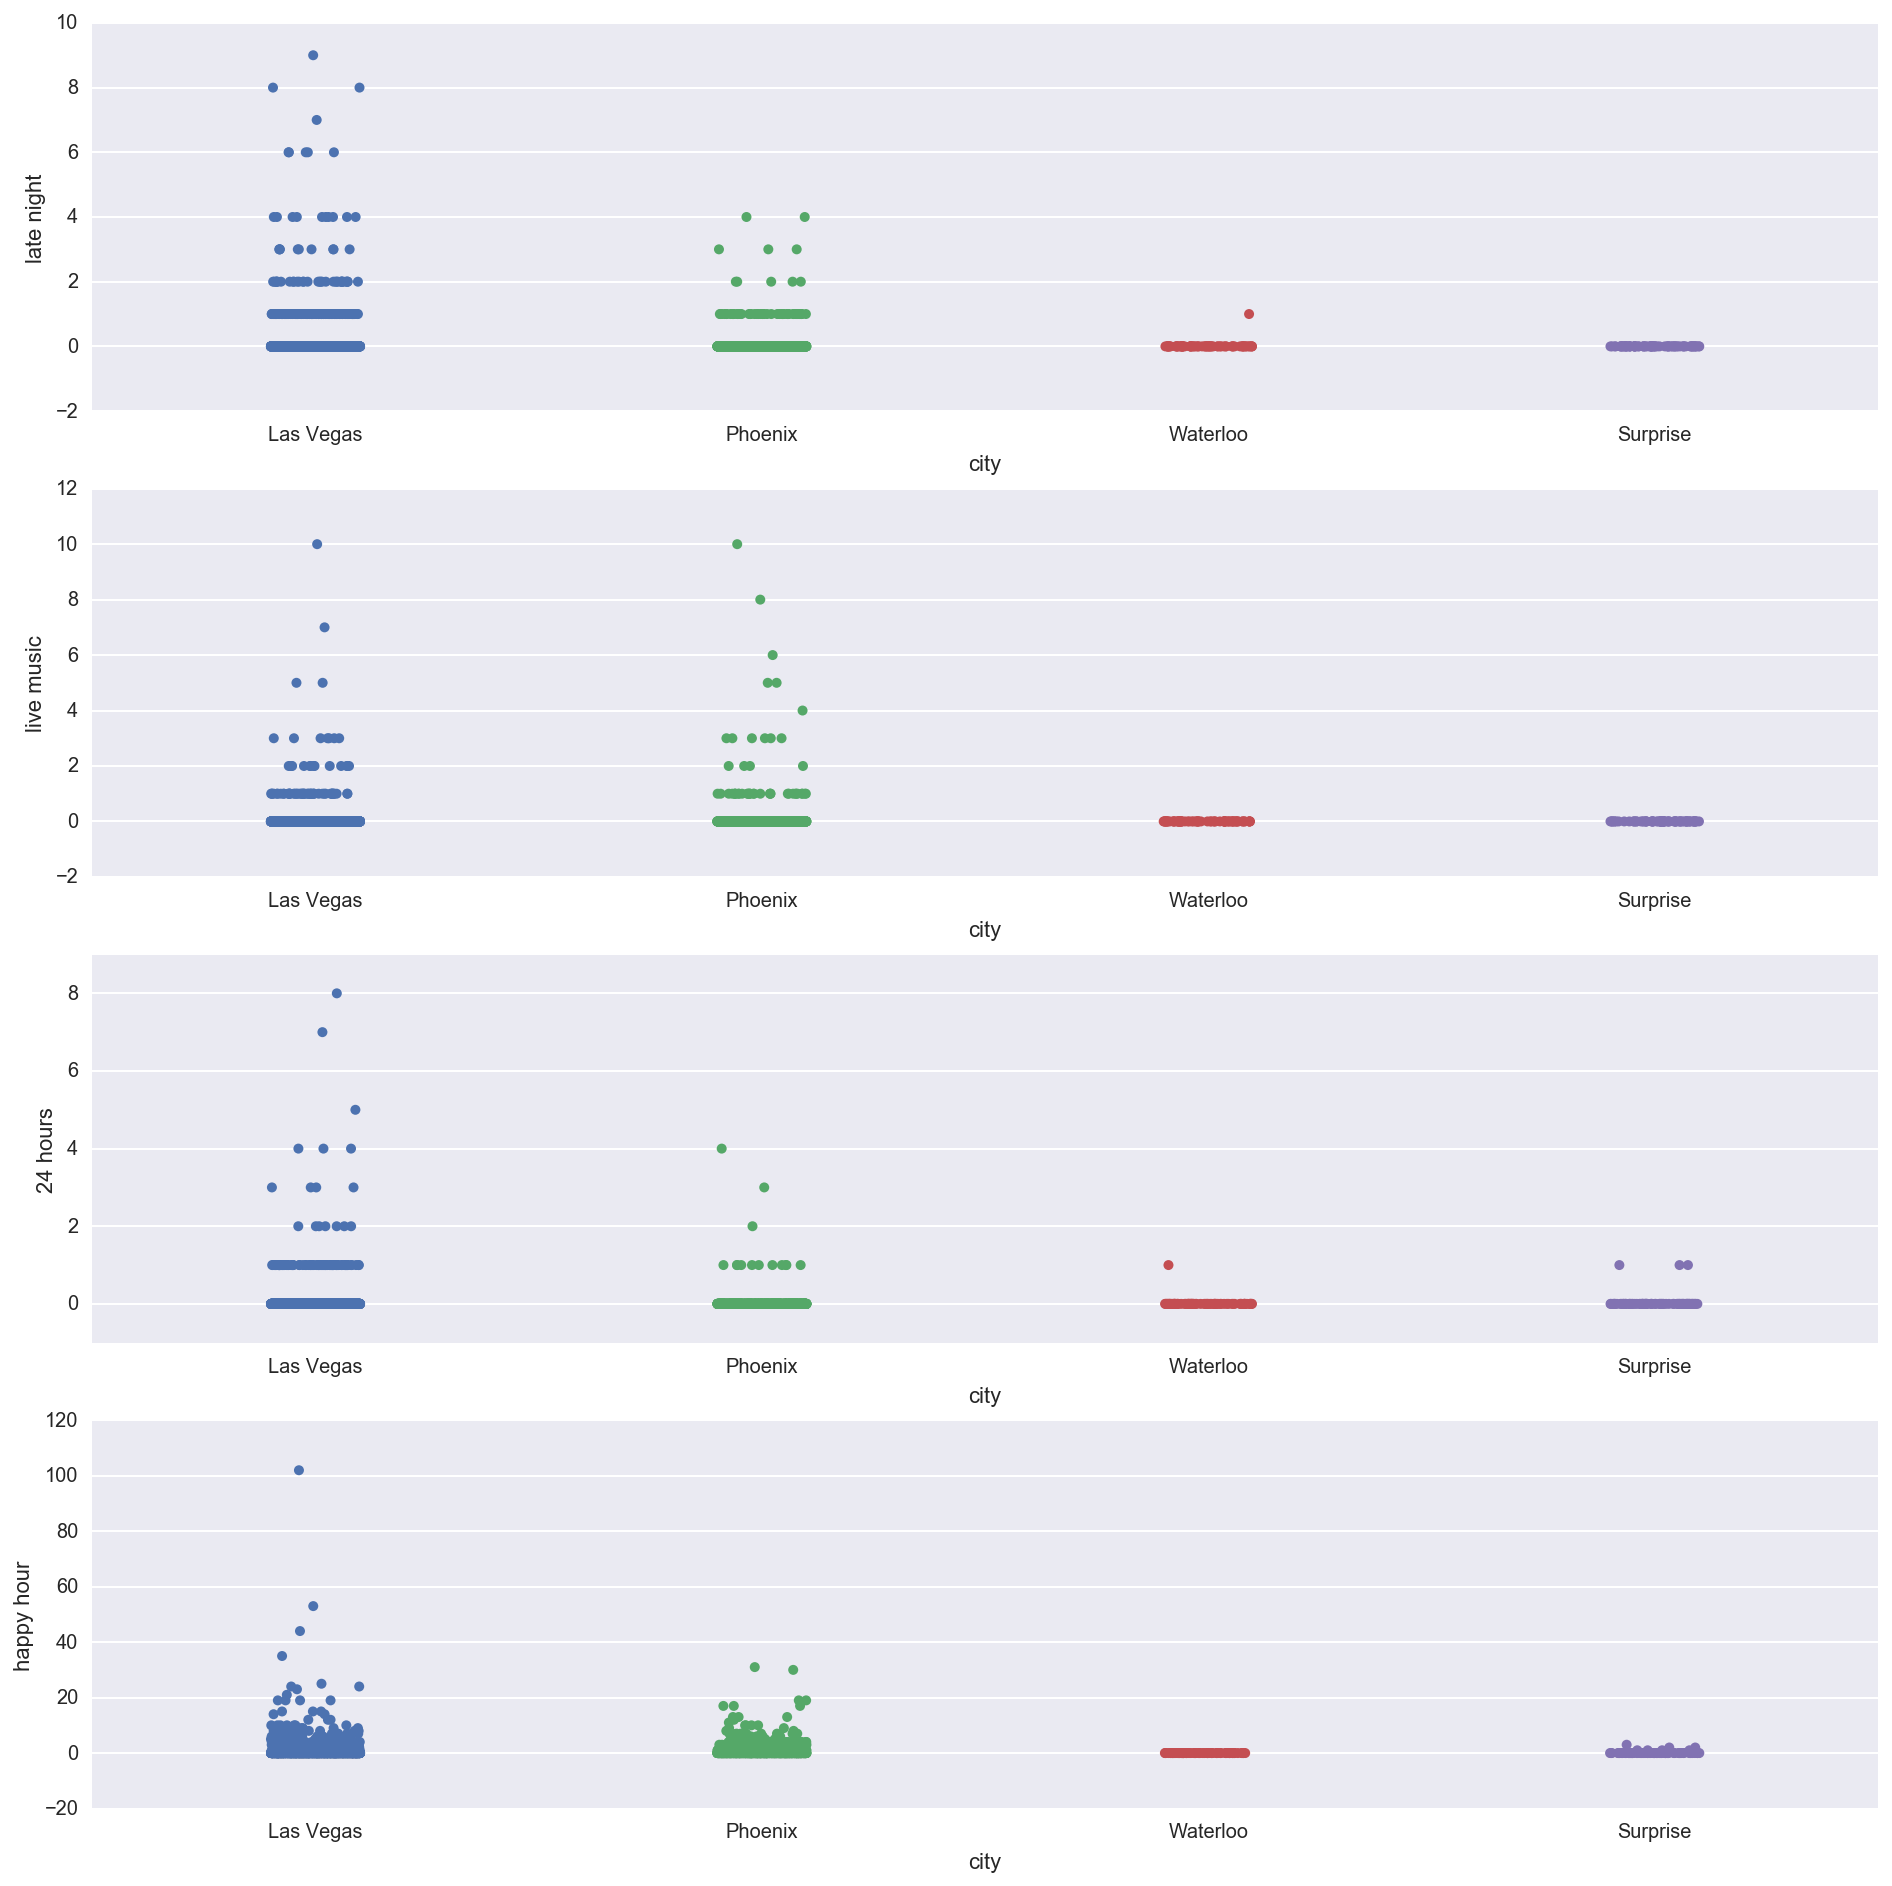

In [113]:
tips.head()
business_wide.head()
tips_by_bus_city = pd.merge(business_wide[['business_id','city']],tips,how='left',on='business_id')

z = [x for x in tips_by_bus_city.columns if x not in ['user_id','business_id','city','las vegas','date']]
tips_sum = tips_by_bus_city.groupby(['business_id','city'])[z].sum().reset_index()

tips_sum = tips_sum.fillna(0)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, figsize=(16,16))

sns.stripplot(x='city',y='late night', jitter=True, data=tips_sum, ax=ax1)
sns.stripplot(x='city',y='live music', jitter=True, data=tips_sum, ax=ax2)
sns.stripplot(x='city',y='24 hours'  , jitter=True, data=tips_sum, ax=ax3)
sns.stripplot(x='city',y='happy hour', jitter=True, data=tips_sum, ax=ax4)

tip_model_cols = ['city','late night','live music','24 hours','happy hour','worth wait']

plt.show()

#24 hours and late night are two of the variables that have a few more ratings than the other 3 cities. 
# tips_sum is df that will merge with to make model.

In [114]:
# Not seeing anything in users data frame that looks useful to include in model for predicting a city. 
users.head(1)

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199


In [115]:
#Defining sets of columns. Will help with feature creation/selection
cols_to_include = ['hours.Monday.close','hours.Tuesday.close','hours.Wednesday.close','hours.Thursday.close','hours.Friday.close'
,'hours.Saturday.close','hours.Sunday.close','attributes.Open 24 Hours','attributes.Price Range'
,'attributes.Good For Dancing','attributes.Good For Groups','attributes.Good For.latenight','attributes.Music.live'
,'attributes.Parking.validated','attributes.Parking.valet','attributes.Noise Level']
hours_cols = ['hours.Monday.close','hours.Tuesday.close','hours.Wednesday.close','hours.Thursday.close','hours.Friday.close'
            ,'hours.Saturday.close','hours.Sunday.close']
bool_cols = ['attributes.Open 24 Hours','attributes.Good For Dancing','attributes.Good For Groups','attributes.Good For.latenight',
             'attributes.Music.live','attributes.Parking.validated','attributes.Parking.valet']
ordinal_cols = ['attributes.Price Range','attributes.Noise Level']

In [116]:
#Converting time closed columns to 1 if close before 5 AM (assuming these are the super late night places which 
#are probably more likely in Vegas)
def check_late_hours(series):
    time = pd.to_datetime(series, format='%H:%M', errors='coerce')
    try:
        if time.hour <= 5:
            return 1
        else:
            return  0
    except:
        return 0

hours_cols = ['hours.Monday.close','hours.Tuesday.close','hours.Wednesday.close','hours.Thursday.close','hours.Friday.close'
            ,'hours.Saturday.close','hours.Sunday.close']

for c in hours_cols:
    business_wide[c] = business_wide[c].map(check_late_hours)

In [117]:
#Updating the boolean feature columns to be 1 for yes and 0 for no
business_wide = pd.get_dummies(business_wide,columns=bool_cols,drop_first=True)
new_bool_cols = [x + '_True' for x in bool_cols]
business_wide[new_bool_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4132 entries, 0 to 4131
Data columns (total 7 columns):
attributes.Open 24 Hours_True         4132 non-null float64
attributes.Good For Dancing_True      4132 non-null float64
attributes.Good For Groups_True       4132 non-null float64
attributes.Good For.latenight_True    4132 non-null float64
attributes.Music.live_True            4132 non-null float64
attributes.Parking.validated_True     4132 non-null float64
attributes.Parking.valet_True         4132 non-null float64
dtypes: float64(7)
memory usage: 226.0 KB


In [118]:
#Price range already numeric. Need to update noise level to be oridinal as well. 
business_wide[ordinal_cols]['attributes.Price Range'].unique()
business_wide[ordinal_cols]['attributes.Noise Level'].unique()
loud_dic = {'very_loud':4,'loud':3,'average':2,'quiet':1,np.nan:0}

business_wide['attributes.Noise Level'] = business_wide[ordinal_cols]['attributes.Noise Level'].map(loud_dic)

In [119]:
#Merging all of the seperate df to get 1 df with all of the features to model.
model_cols = ['city','business_id'] + hours_cols + ordinal_cols + new_bool_cols
city_model = business_wide[model_cols]
city_model = pd.merge(city_model,check_bybusiness,how='left',on='business_id')
city_model = pd.merge(city_model,tips_sum,how='left',on=['business_id','city'])
city_model = pd.merge(city_model,business_reviewers,how='left',on='business_id')

#Convert target to binary
city_model.city = city_model.city.map(lambda x: 1 if x == 'Las Vegas' else 0)
city_model.head(1)

variable,city,business_id,hours.Monday.close,hours.Tuesday.close,hours.Wednesday.close,hours.Thursday.close,hours.Friday.close,hours.Saturday.close,hours.Sunday.close,attributes.Price Range,...,user_id_ysBQMZiuZ7VSu_YAh-lE0Q,user_id_z0EwyTRBfjtIZfKr73jAHQ,user_id_zIWHwd2lpPVegydJtauKxg,user_id_zPkj64w6rvCpXsv6Ti8Tnw,user_id_zTWH9b_ItSdLOK9ypeFOIw,user_id_za-RWjEpB9W_34NW4vS7HQ,user_id_zbUpiea2aiJSKXjj2zQ5yw,user_id_zfysCL-0uQNCWdGvzZ6QWA,user_id_zo2PHkxPCVvyo9AoCwCb3g,user_id_zs_GJibScPz5Cbz1hoNanQ
0,1,--jFTZmywe7StuZ2hEjxyA,0,0,0,0,0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
features = city_model.columns[1:]
x_string = ' + '.join(features)

formula = 'city ~ ' + x_string

#Patsy is not very forging on column names. Slicing it is...
#y,X = patsy.dmatrices(formula, city_model, return_type = 'dataframe')
y = city_model[['city']]
X = city_model.iloc[:,2:]

#filling in NAs for user_ids
X.fillna(value=0,inplace=True)

In [341]:
#running model to get idea of score
logreg = LogisticRegression()
model = logreg.fit(X,np.ravel(y))
score = logreg.score(X,np.ravel(y))
print score

#97 for the win! 

0.975695966681


In [342]:
knn = KNeighborsClassifier()
model = knn.fit(X,np.ravel(y))
score = knn.score(X,np.ravel(y))
print score
#performance is about the same! 

0.979504603244


In [197]:
#Now for some gridsearch and cv goodness to make sure we didn't just get lucky
lr_param = {
            'penalty':['l1','l2'],
            'fit_intercept':[True,False],
            'solver':['liblinear'],
            'C':np.linspace(0.05,1,10)
           }


gs_lr = GridSearchCV(logreg,lr_param,cv=5,verbose=1)


lr_model = gs_lr.fit(X,np.ravel(y))
lr_score = gs_lr.score(X,np.ravel(y))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  3.5min
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 13.8min
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.9min finished


In [333]:
knn_param = {
            'n_neighbors':range(1,30,3),
            'weights':['uniform','distance']
}  

gs_knn = GridSearchCV(knn,knn_param,cv=5,verbose=1)

knn_model = gs_knn.fit(X,np.ravel(y))
knn_score = gs_knn.score(X,np.ravel(y))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed: 511.1min
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 619.8min finished


In [ ]:
print lr_score
print knn_score

my_dic = [(a,b) for a,b in zip(X.columns,np.nditer(logreg.coef_))]
df = pd.DataFrame(my_dic)
df['abs_coeff'] = np.abs(df[1])
df.rename(columns={0:'variable',1:'value'},inplace=True)
df.sort_values(by='abs_coeff',ascending=False)[[0,1]]

In [124]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

def plot_roc(mod, X, y, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    fpr_, tpr_, _ = roc_curve(y, y_pp)
    auc_ = auc(fpr_, tpr_)
    acc_ = np.abs(0.5 - np.mean(y)) + 0.5
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(fpr_, tpr_, label='ROC (area = %0.2f)' % auc_,
             color='darkred', linewidth=4,
             alpha=0.7)
    axr.plot([0, 1], [0, 1], color='grey', ls='dashed',
             alpha=0.9, linewidth=4, label='baseline accuracy = %0.2f' % acc_)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('false positive rate', fontsize=16)
    axr.set_ylabel('true positive rate', fontsize=16)
    axr.set_title(varname+' vs. not ROC curve\n', fontsize=20)

    axr.legend(loc="lower right", fontsize=12)

    plt.show()
    

def plot_prauc(mod, X, y, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_pp)
    avg_precision = average_precision_score(y, y_pp)
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(recall, precision, label='PRAUC (area = %0.2f)' % avg_precision,
             color='steelblue', linewidth=4,
             alpha=0.7)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('recall', fontsize=16)
    axr.set_ylabel('precision', fontsize=16)
    axr.set_title(varname+' vs. not PRAUC curve\n', fontsize=20)

    axr.legend(loc="upper right", fontsize=12)

    plt.show()

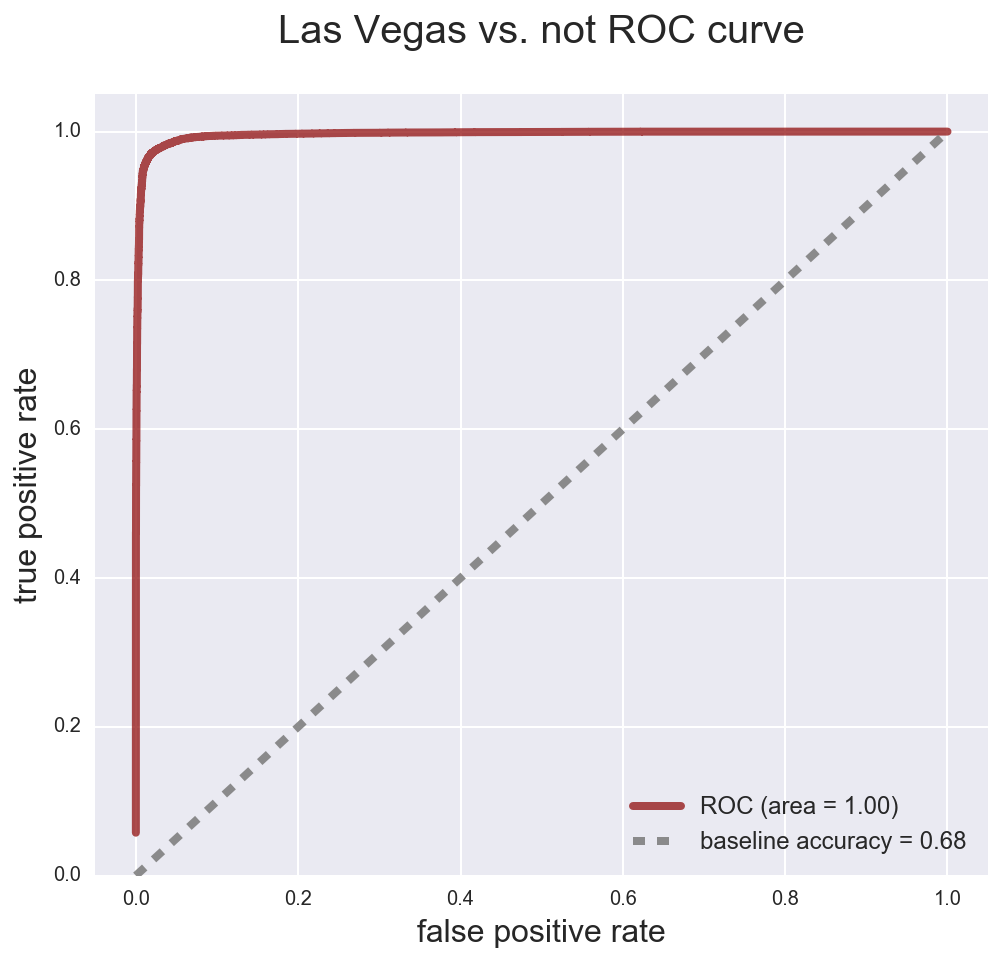

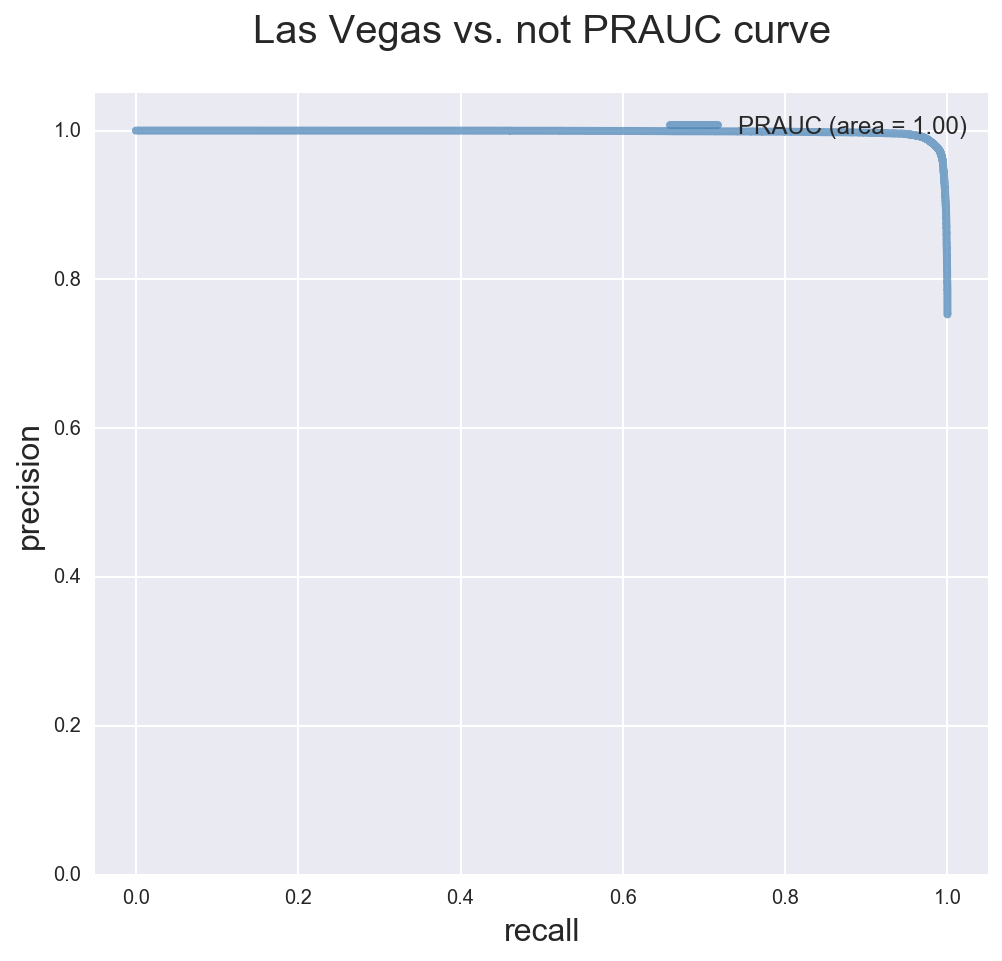

In [125]:
plot_roc(logreg,X,np.ravel(y),'Las Vegas')
plot_prauc(logreg,X,np.ravel(y),'Las Vegas')

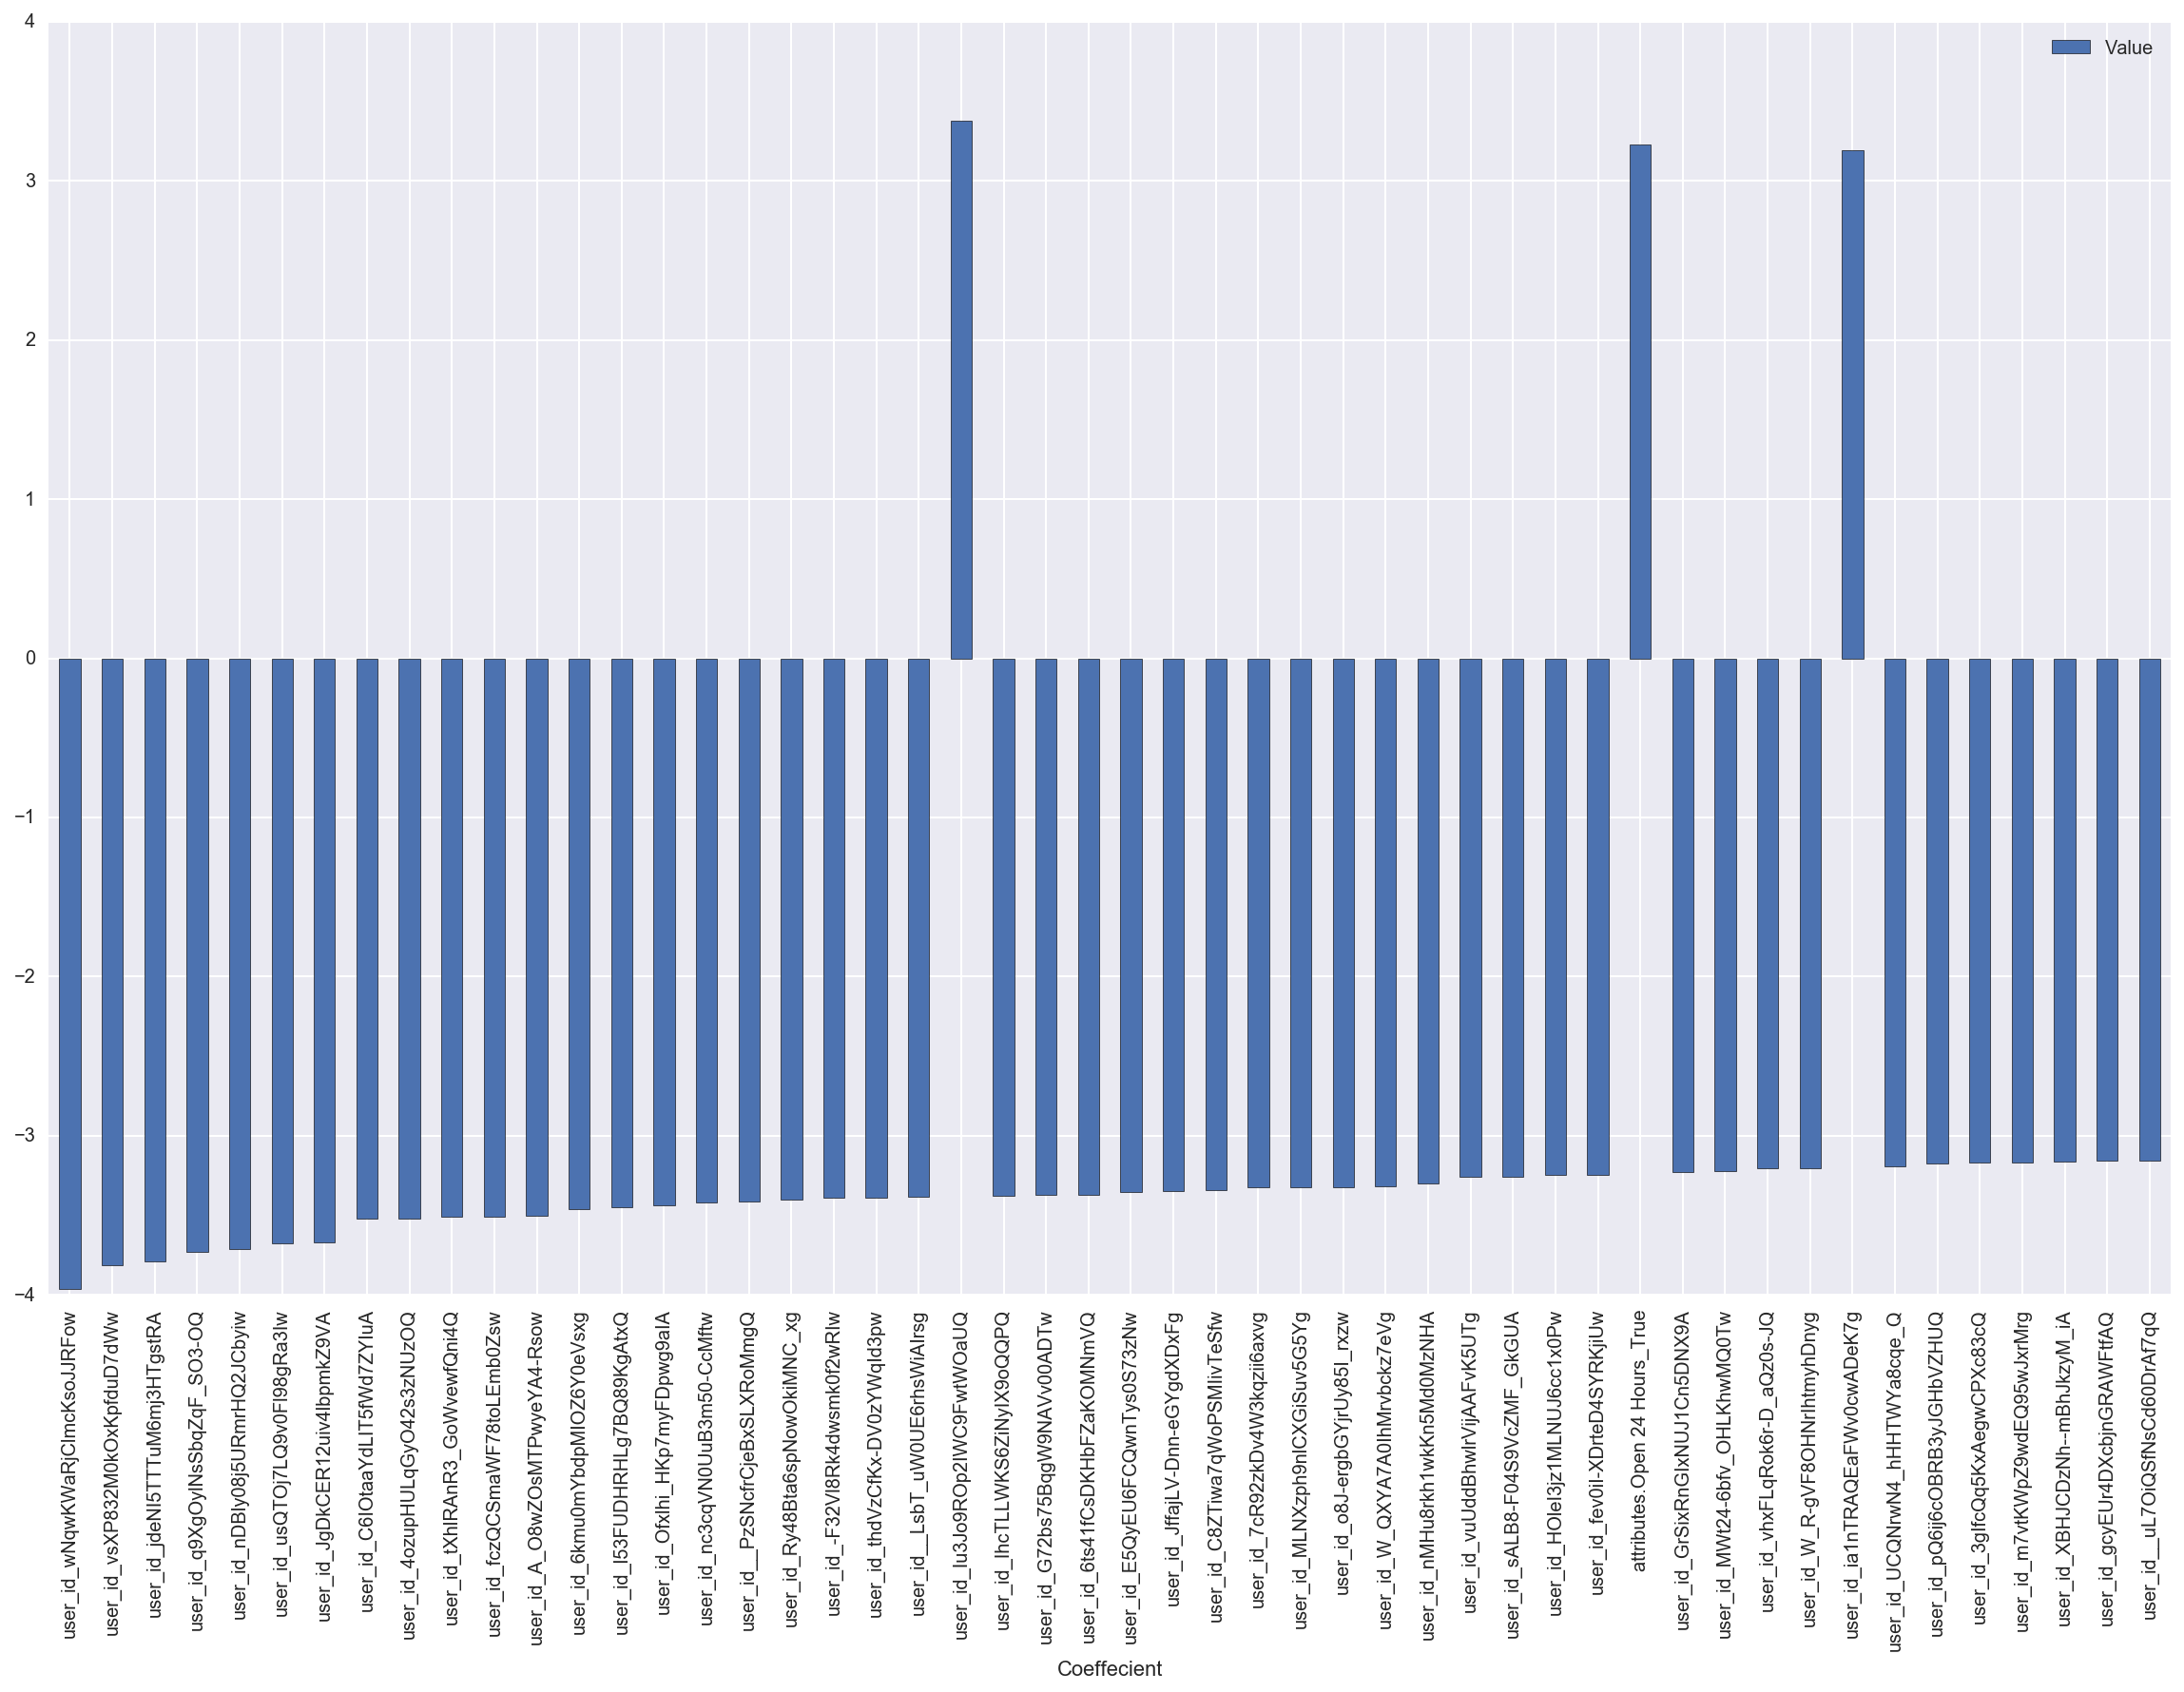

In [380]:
log_coef = pd.DataFrame([(col_name,coef) for coef,col_name in zip(np.nditer(logreg.coef_),X.columns)],columns=['Coeffecient','Value'])
log_coef['abs_val'] = abs(log_coef.Value)
log_coef.sort_values(by='abs_val',ascending=False,inplace=True)
#log_coef.plot(kind='bar',x='Coeffecient',y='Value')
#pd.to_numeric(log_coef.Value,errors='raise')
#pd.to_numeric(log_coef.Value.head(1))
def wtf(series):
    return np.float64(series).item()
    
log_coef.Value = log_coef.Value.map(wtf)

fig = plt.figure(figsize=(20,12))
ax = fig.gca()
log_coef.head(50).plot(kind='bar',x='Coeffecient',y='Value',ax=ax)
plt.show()

# As expected the users were our most powerful feature. In fact that top 50 features are all users. This problem
# ended up working out as effectivley a recommender system relying on finding users that had reviewed multiple
# businesses in one city.

# The model scores very well. The accuracy is pushing 98% against a baseline of only 68%. The ROC and precision scores
# are both extremely high ~1. This model is good enough to take to Vegas and bet the house. $$$$ on red!!!

# The corrolary to this would be understanding how to deal with problems like this where we can end up with as 
# many if not more features then we have samples. The matrices get huge and very sparse which requires a lot more
# horepower than my poor MBP has using my naive model...

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [127]:
food_cols = ['happy hour','bar food','fast food','food amazing','food came','food delicious','food good','food great','food just',
             'food service','good food','great food','quality food','service food','mashed potatoes','medium rare','hash browns','ice cream',
            'bar food','beer selection','bloody mary','chicken waffles','eggs benedict','potato fries','onion rings',
            'fish chips','french fries','french toast','fried chicken','mac cheese','red velvet','sweet potato','tasted like']

service_cols = ['bottle service','customer service','food service','good service','great service','service excellent',
                'service food','service friendly','service good','service great','great atmosphere','great experience',
                'friendly staff','staff friendly','wait staff','super friendly','10 minutes','15 minutes','20 minutes',
                '30 minutes','slow service','awesome service','excellent service','fast service','friendly service',
                'great customer','great staff','long wait','slow service']

other_cols = ['decided try','definitely come','didn want','don know','don like','don think','don want','feel like',
              'friday night','good place','good thing','good time','great place','great time','little bit','just right',
              'las vegas','highly recommend','definitely recommend','friendly staff','votes.cool',
              'votes.funny','votes.useful','best ve','dance floor','felt like','happy hour',
              'hip hop','just like','just ok','late night','like place','long time','looked like',
              'looks like','love place','make sure','minutes later','new york','place good','place great','place just',
              'pretty good','really enjoyed','really good','really like','really nice','recommend place','right away',
              'saturday night','second time','time vegas','try place','ve seen','ve tried','likes', '24 hours', 
              'amazing food', 'animal style', 'awesome food', 'awesome place', 'beef hash', 'best breakfast', 
              'best burger', 'best burgers', 'best place', 'carne asada', 'cheese fries', 'come early', 'cool place', 
              'corned beef', 'delicious food', 'don come', 'don forget', 'excellent food', 'favorite place', 
              'food awesome', 'food drinks', 'free wifi', 'gluten free', 'great beer', 'great breakfast', 
              'great burgers', 'great drinks', 'great happy', 'great prices', 'great spot', 'grilled cheese', 
              'guest list', 'happy birthday', 'live music', 'love food', 'love love', 'new favorite', 'nice place', 
              'nom nom', 'open 24', 'place awesome', 'place eat', 'prime rib', 'staff great', 'steak eggs', 
              'velvet pancakes', 'worth wait'] + food_cols

review_service_cols = [x for x in reviews.columns if x in service_cols]
review_other_cols = [x for x in reviews.columns if x in other_cols]
reviews['service_score'] = reviews.loc[:,review_service_cols].sum(axis=1)
reviews['other_score'] = reviews.loc[:,review_other_cols].sum(axis=1) 
reviews[['service_score','other_score']]
reviews['stars_service'] = 0
reviews['stars_other'] = 0

reviews.loc[(reviews.service_score >= reviews.other_score),'stars_service'] = reviews.stars
reviews.loc[~(reviews.service_score >= reviews.other_score),'stars_other'] = reviews.stars

In [ ]:
X['stars']

In [128]:
all_cols = other_cols + food_cols
reviews[['service_score','other_score','stars_service','stars_other']]
x_cols = [x for x in reviews.columns if x in all_cols]

#Defining design matrix and targets
service_mask = (reviews.stars_service != 0)
Xs =  reviews.loc[service_mask,x_cols]
Xns = reviews.loc[~service_mask,x_cols]
y_service = reviews.loc[service_mask,'stars_service']
y_service_no = reviews.loc[~service_mask,'stars_other']

en_s = ElasticNetCV()
model_s = en.fit(Xs,y_service)
score_s = en.score(Xs,y_service)
print 'R^2 for service stars: ',score_s

en_ns = ElasticNetCV()
model_ns = en_ns.fit(Xns,y_service_no)
score_ns = en_ns.score(Xns,y_service_no)
print 'R^2 for no service stars: ',score_ns                   

R^2 for service stars:  0.0374751642341
R^2 for no service stars:  0.181640338344


In [131]:
from scipy.stats import ttest_rel
from scipy import stats

print y_service.describe().T
print y_service_no.describe().T

#The mean and the standard deviation of the two subsets seems pretty close at first glance using describe. 


stats.ttest_ind(y_service,y_service_no)

# The t-test/P-value mean we can be almost certain that there is a statisctically signifcant difference between 
# the means of the two samples. That said given such a large sample size we can't put a ton of weight into this. 
# The next thing to check is the effect size. 

count    85582.000000
mean         3.782408
std          1.339855
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: stars_service, dtype: float64
count    236816.000000
mean          3.734710
std           1.290063
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: stars_other, dtype: float64


0.036593114239975459

In [132]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)* np.std(y, ddof=1) ** 2) / dof)

cd = cohen_d(y_service,y_service_no)
# Next step is to check the effect size. Given a score of ~0.04 I will conclude that there is not a meaningful 
# difference in the means. 

0.036593114239975459

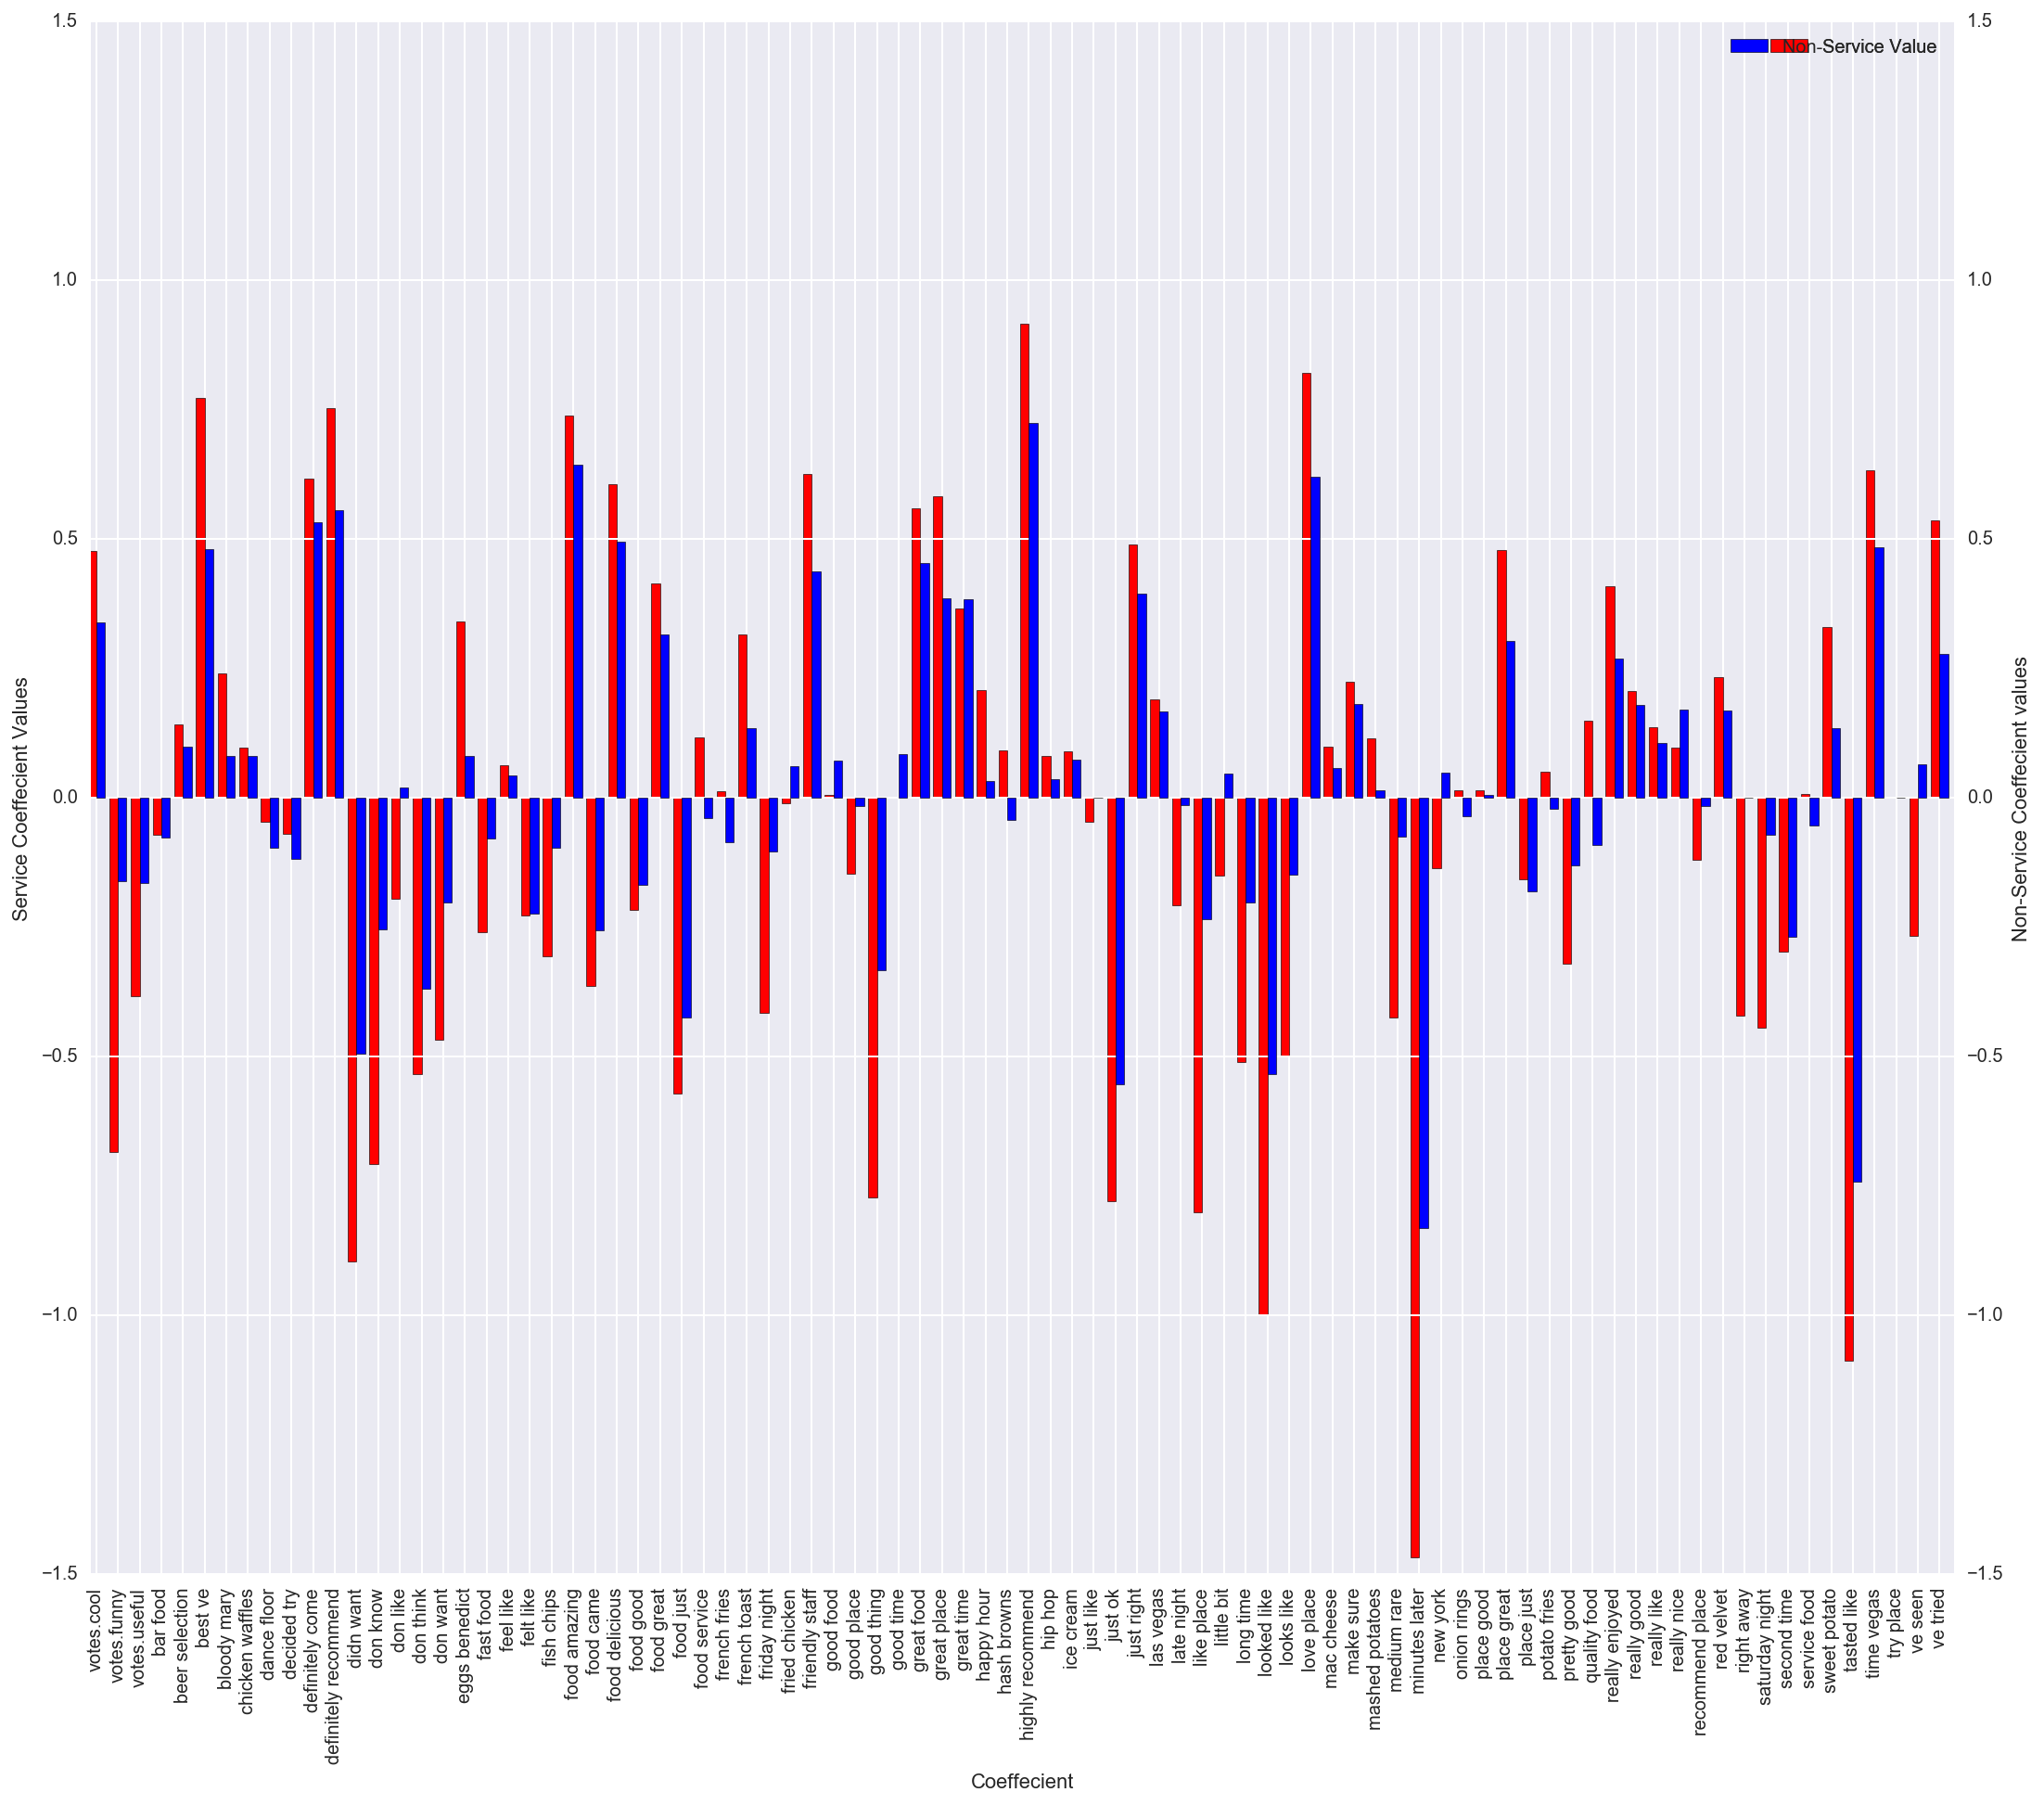

In [334]:
ns_coef = pd.DataFrame([(col_name,coef) for coef,col_name in zip(model_ns.coef_,Xns.columns)],columns=['Coeffecient','Value'])
ns_coef['abs_val'] = abs(ns_coef.Value)
ns_coef.sort_values(by='abs_val',ascending=False)

s_coef = pd.DataFrame([(col_name,coef) for coef,col_name in zip(model_s.coef_,Xs.columns)],columns=['Coeffecient','Value'])
s_coef['abs_val'] = abs(s_coef.Value)
s_coef.sort_values(by='abs_val',ascending=False)

coef_values = pd.merge(s_coef,ns_coef,how='inner',on='Coeffecient')
coef_values.rename(columns={'Value_x':'Service Value','Value_y':'Non-Service Value'},inplace=True)
#coef_values

fig = plt.figure(figsize=(18,15))
#ax = fig.gca()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

coef_values.plot(kind='bar',y='Service Value', x='Coeffecient', ax=ax, color='Red', position = 1, width=0.4)
coef_values.plot(kind='bar',y='Non-Service Value', x='Coeffecient', ax=ax2, color = 'Blue', position = 0, width= 0.4)

ax.set_ylabel('Service Coeffecient Values')
ax2.set_ylabel('Non-Service Coeffecient values')

ax.set_ylim([-1.5,1.5])
ax2.set_ylim([-1.5,1.5])


plt.xticks(rotation=80)
plt.legend()
plt.show()


Given the very tiny effect size I would reject hypothesis that there are two fundamentally different type of reviews. This is further illustrated by the plotting of the coeffecients above. These tend to be very similar between the two models, especially for larger impact variables,  with only differences in the magnitudes.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [240]:
users = pd.read_csv('/Users/ryandunlap/Desktop/DSI-SF-2-rddunlap23/datasets/yelp/users_small_parsed.csv')
#Update elite to be binary target if user was ever elite
import ast

def update_elite(series):
    if len(ast.literal_eval(series)) >= 1:
        return 1
    else:
        return 0

    
users.elite = users.elite.map(update_elite)

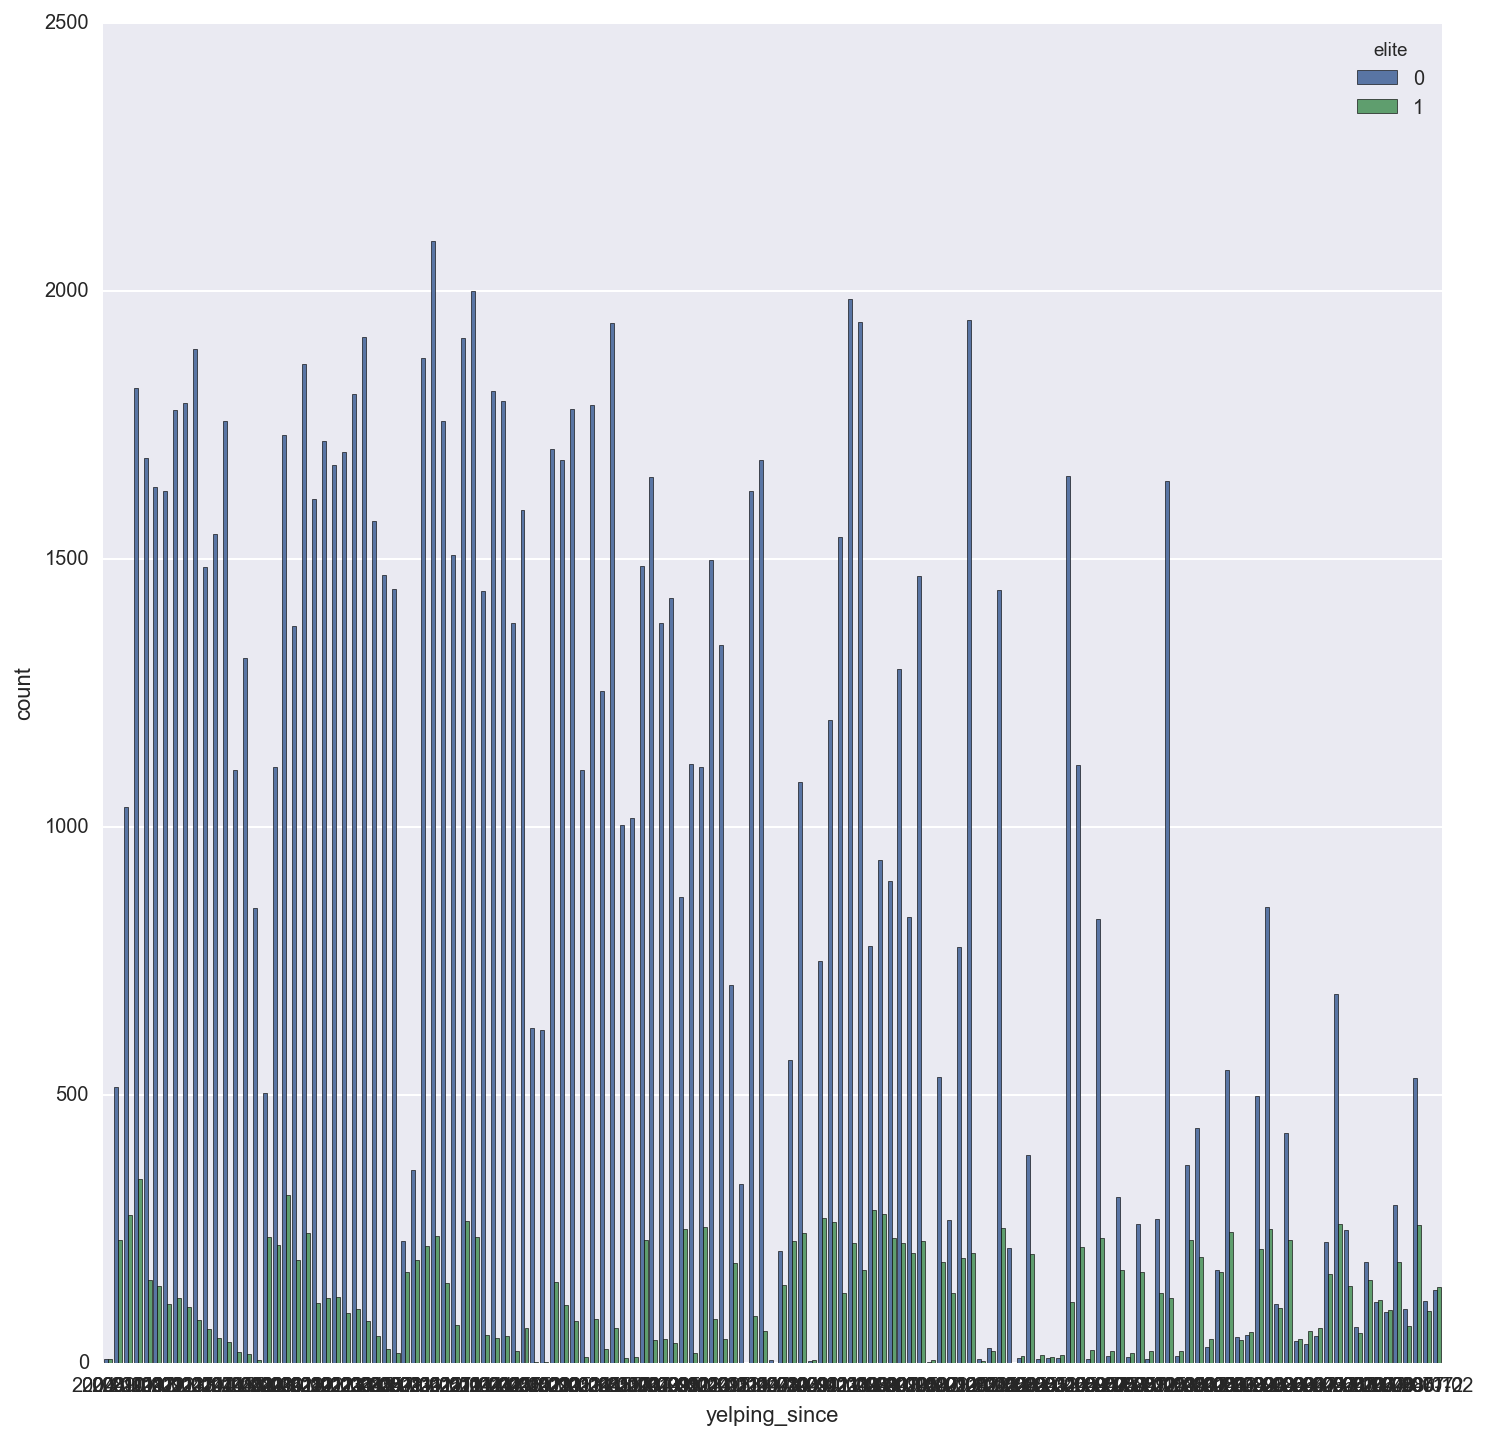

In [241]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
ax = sns.countplot(x='yelping_since',hue='elite',data=users)
plt.show()

# Was entertaining coverting dates to ordinal thinking strong relationship to older users being elite. Disribution of 
# counts doesn't seem to bare that out however. Will leave date out of model.

In [268]:
num_cols = users.select_dtypes(exclude=['object'])
num_cols = num_cols.fillna(value=0)

model_cols = [x for x in num_cols.columns if x != 'elite']

Xe = num_cols.loc[:,model_cols]
ye = num_cols.elite

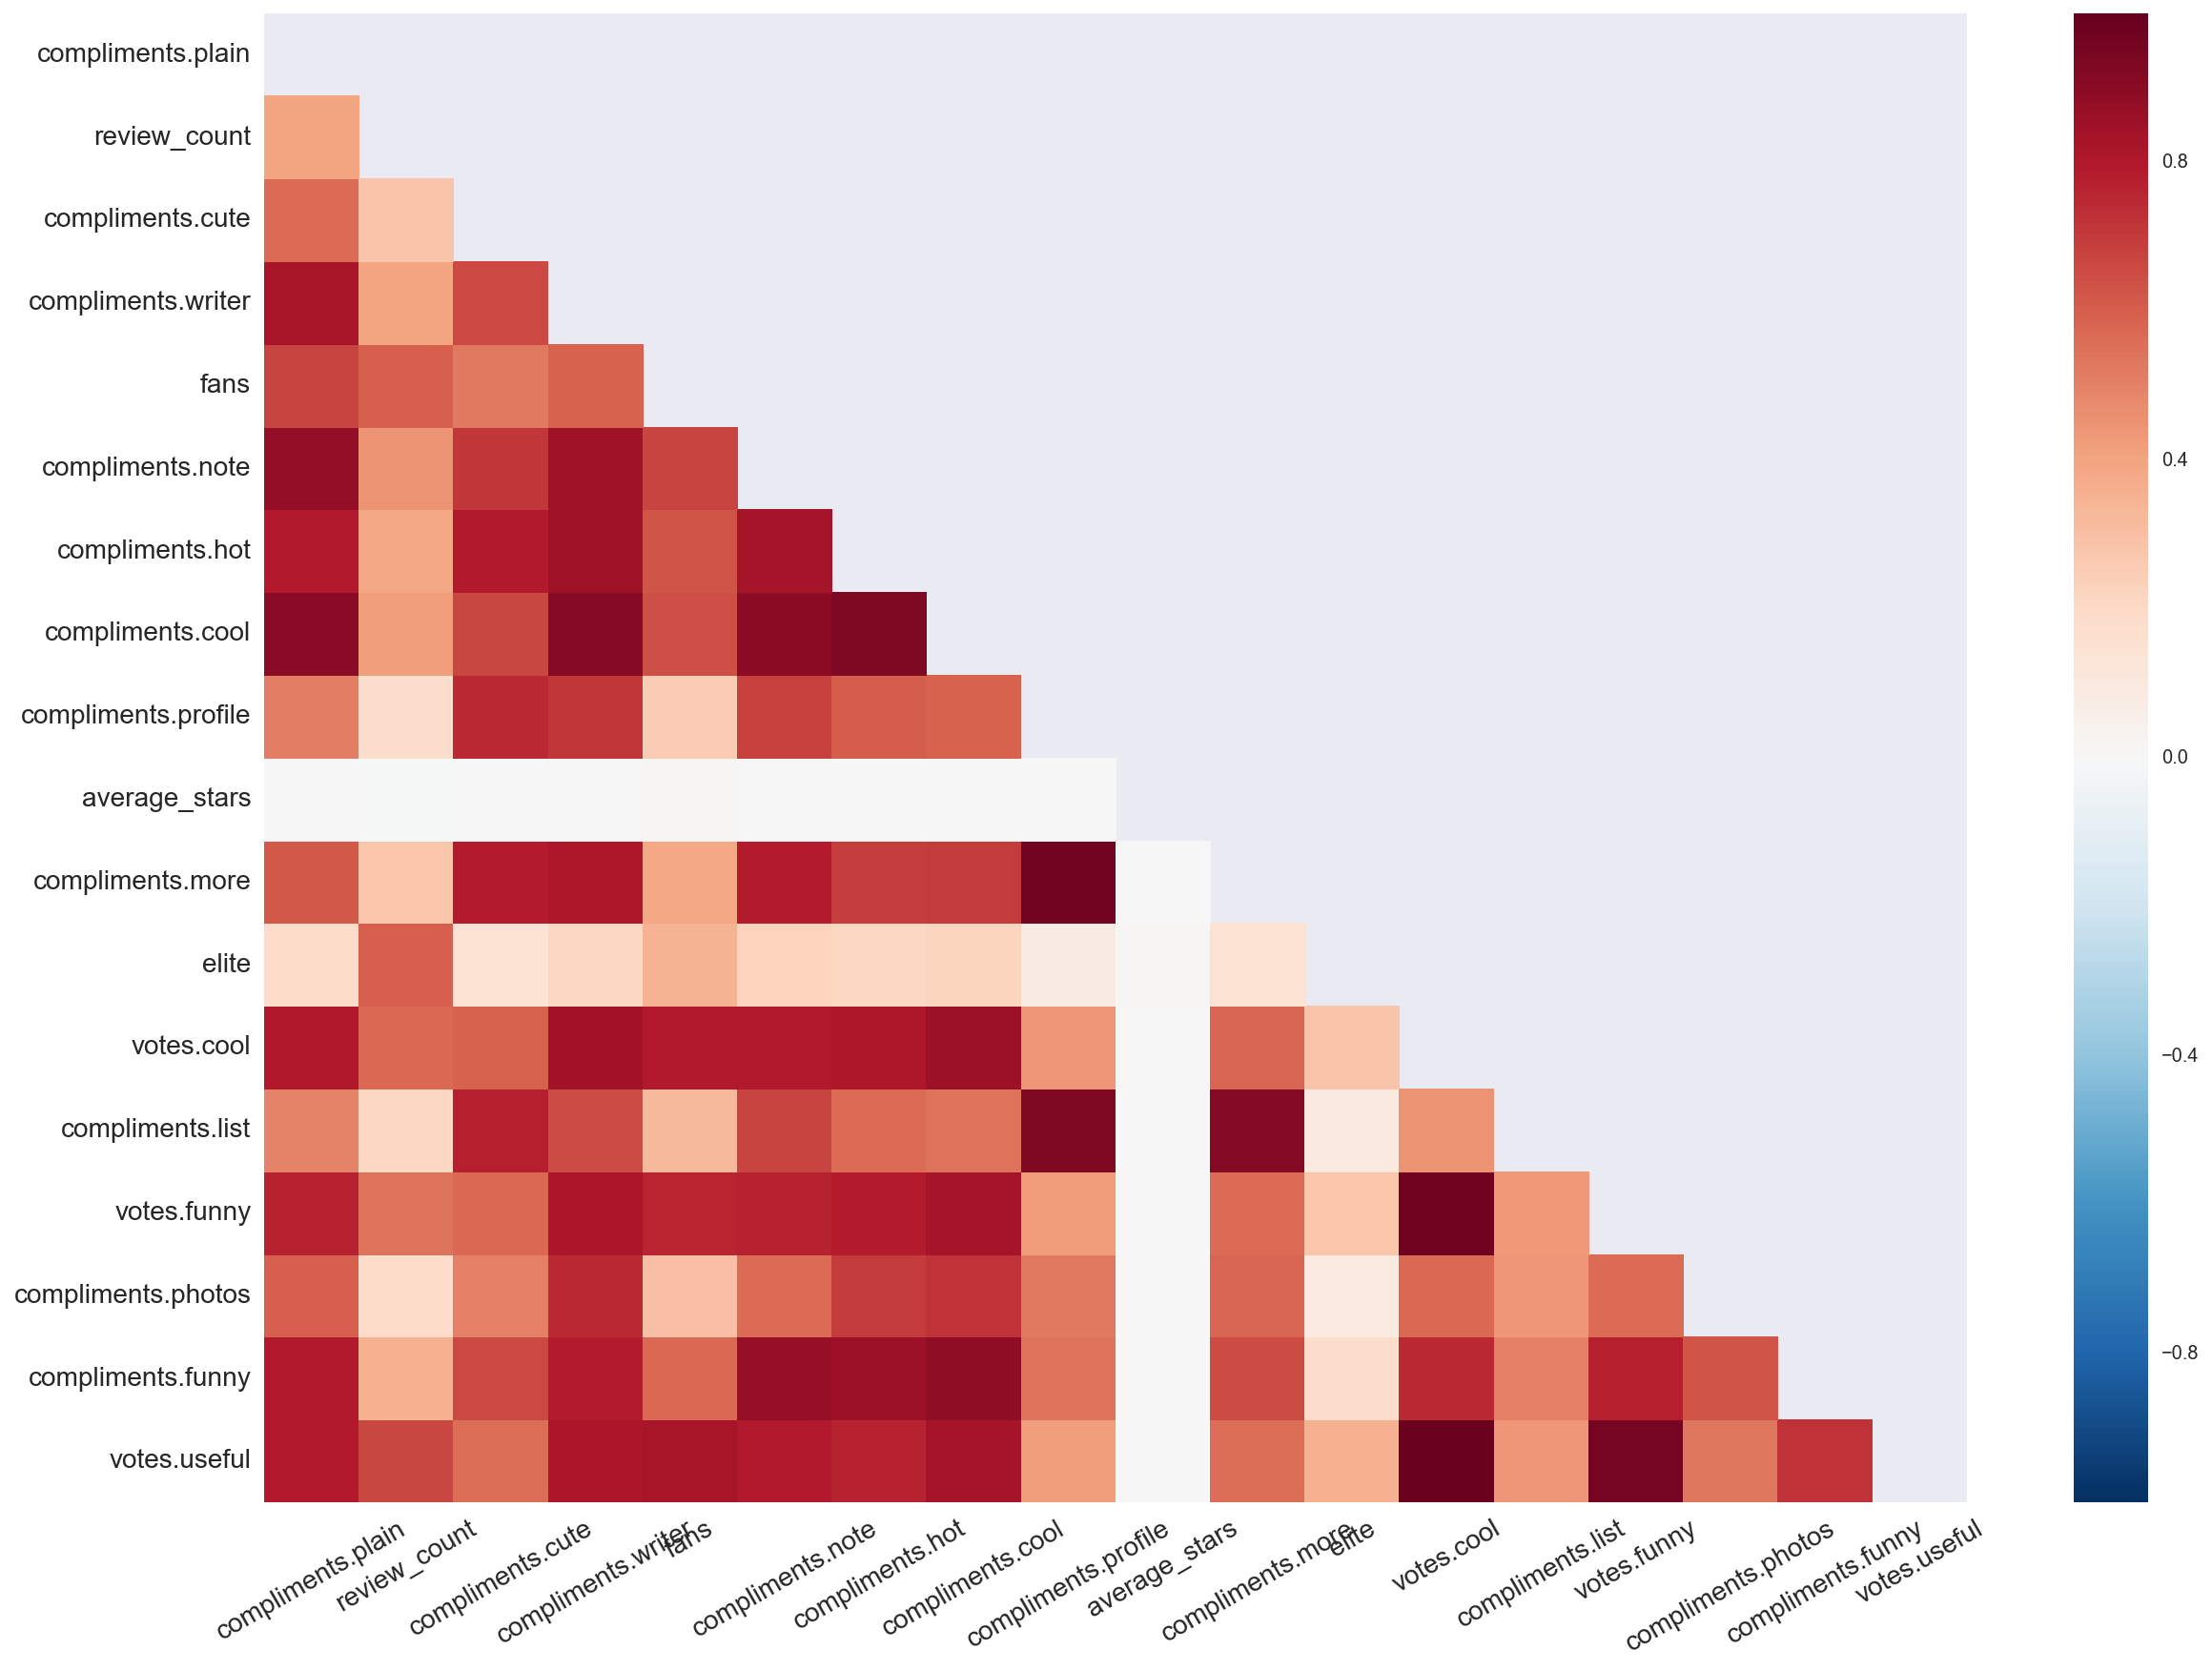

In [283]:
corrs = num_cols.corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(20,14))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corrs, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corrs, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

From the above correlations it's looking like review_count is going to be the only column that helps much...

In [285]:
elr = LogisticRegression()

ss = StandardScaler()
Xen = ss.fit_transform(Xe,ye)
    
gelr_param_grid = {
                'penalty':['l1','l2'],
                'solver':['liblinear'],
                'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] 
}

gelr = GridSearchCV(elr,gelr_param_grid,cv=5,verbose=1)

gelr_model = gelr.fit(Xen,ye)
gelr_score = gelr.score(Xen,ye)

print gelr_score

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  3.5min
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  5.7min finished


0.946978627796


Wow! That was a much better score than I expected.

In [318]:
penalty = gelr.best_params_['penalty']
C = gelr.best_params_['C']

elr = LogisticRegression(penalty = penalty, C=C)
elr_model = elr.fit(Xen,ye)

In [317]:
lr_coef = pd.DataFrame([(k,j) for j,k in zip(np.nditer(elr_model.coef_),Xe.columns)],columns=['Coeffecient','Value'])
lr_coef['abs_val'] = abs(lr_coef.Value)
lr_coef.sort_values(by='abs_val',ascending=False,inplace=True)
lr_coef

,Coeffecient,Value,abs_val
3,compliments.writer,5.59496804952,5.59497
8,compliments.profile,-5.18586094796,5.18586
10,compliments.more,3.96286704127,3.96287
16,votes.useful,3.65457050042,3.65457
13,votes.funny,-2.14979667615,2.1498
7,compliments.cool,2.10897276438,2.10897
1,review_count,1.77291025647,1.77291
11,votes.cool,-1.41750078764,1.4175
4,fans,1.29450185062,1.2945
15,compliments.funny,-1.1986527789,1.19865


In [329]:
[c for c in Xe.columns if 'compliments' not in c if 'count' not in c if 'votes' not in c]
#Stripping out the count column only leaves with 2 features

X2 = Xe[['fans', 'average_stars']]

xlr = LogisticRegression()
xlr_model = xlr.fit(X2,ye)
print 'R^2:',xlr.score(X2,ye)

print np.mean(ye)

# Data set is badly balanced. Accuracy score is much less impressive...

R^2: 0.935418775918
0.115272596147


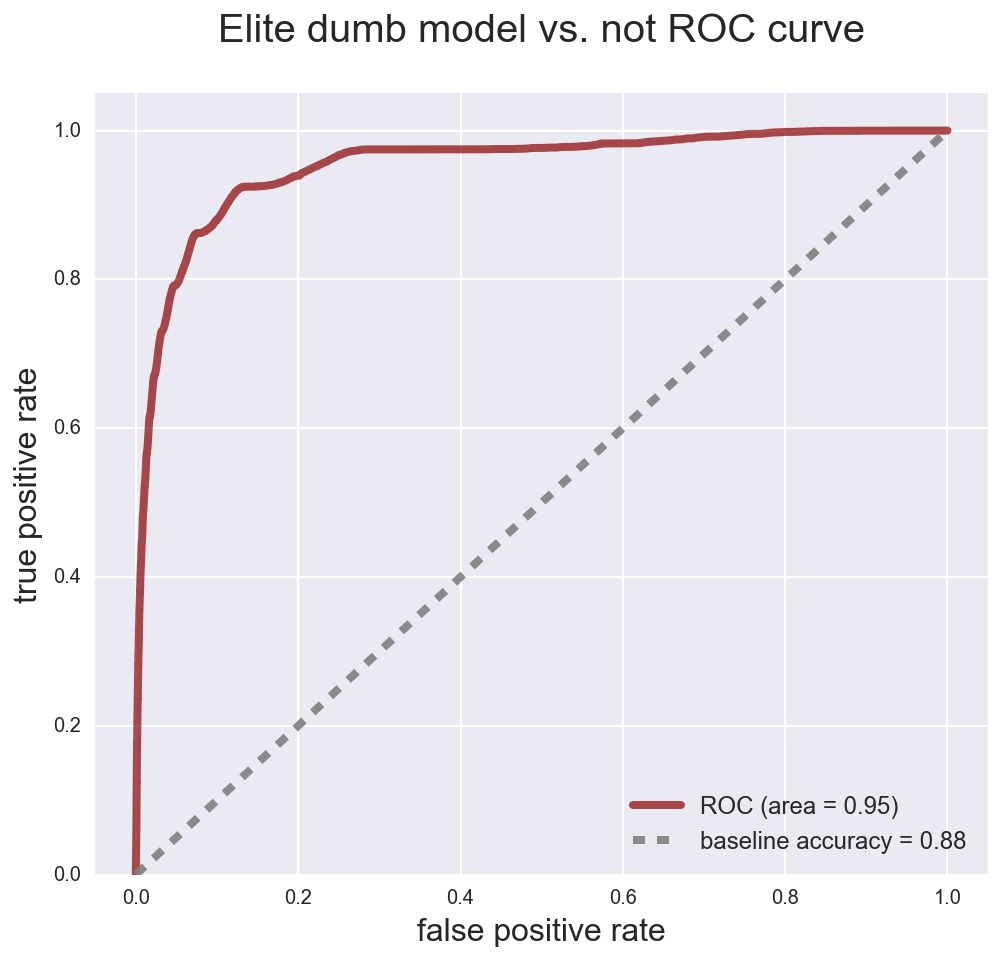

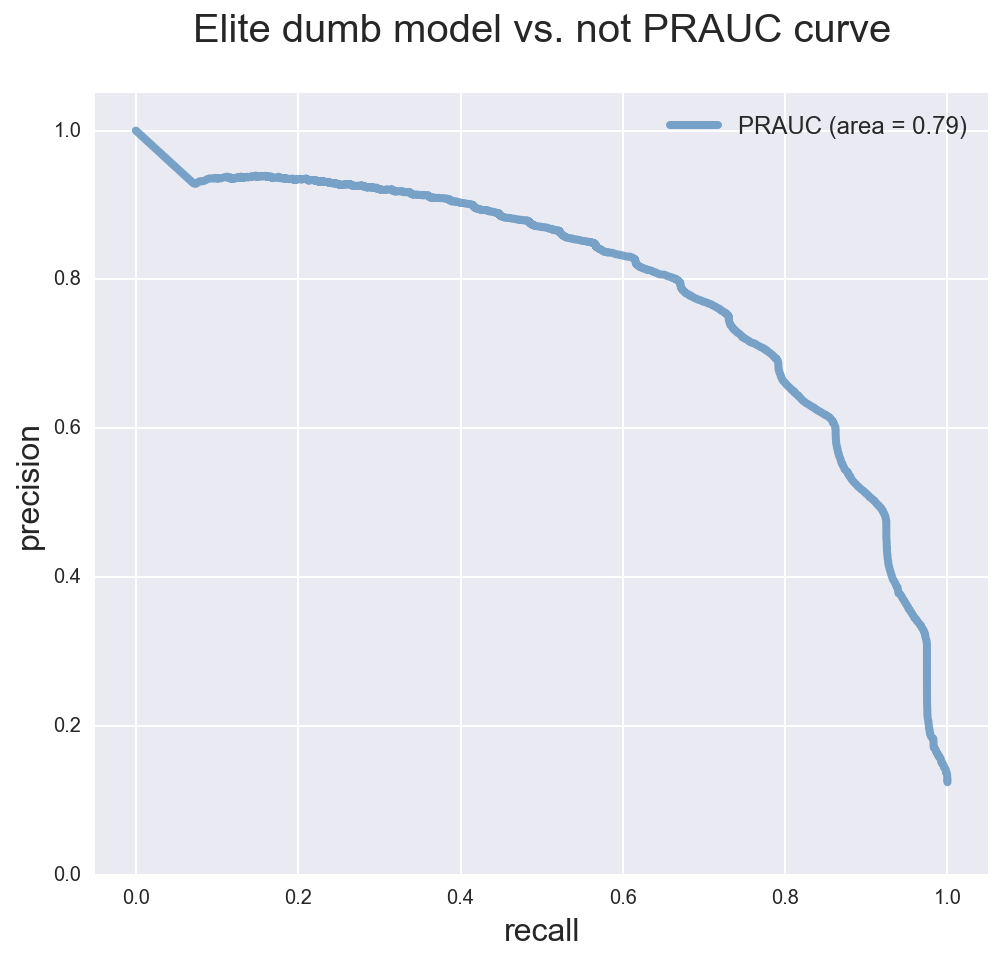

In [330]:
plot_roc(logreg,X2,np.ravel(ye),'Elite dumb model')
plot_prauc(logreg,X2,np.ravel(ye),'Elite dumb model')

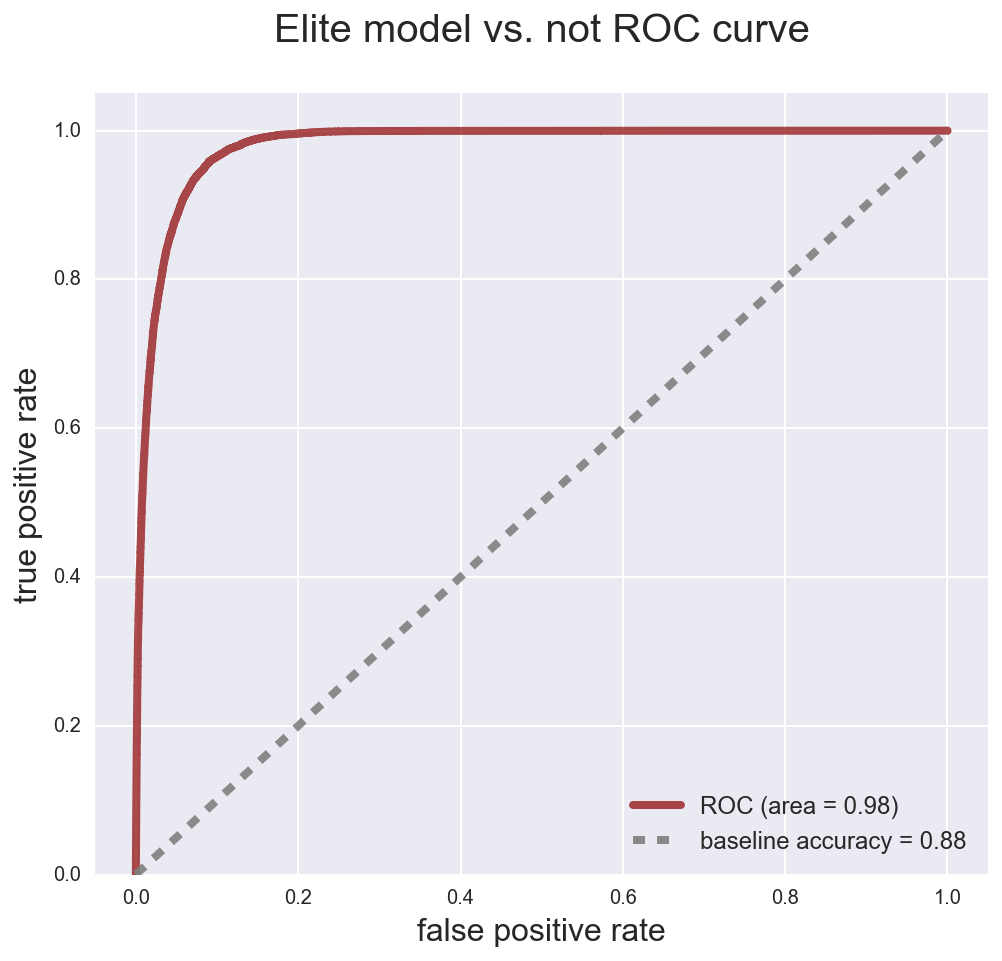

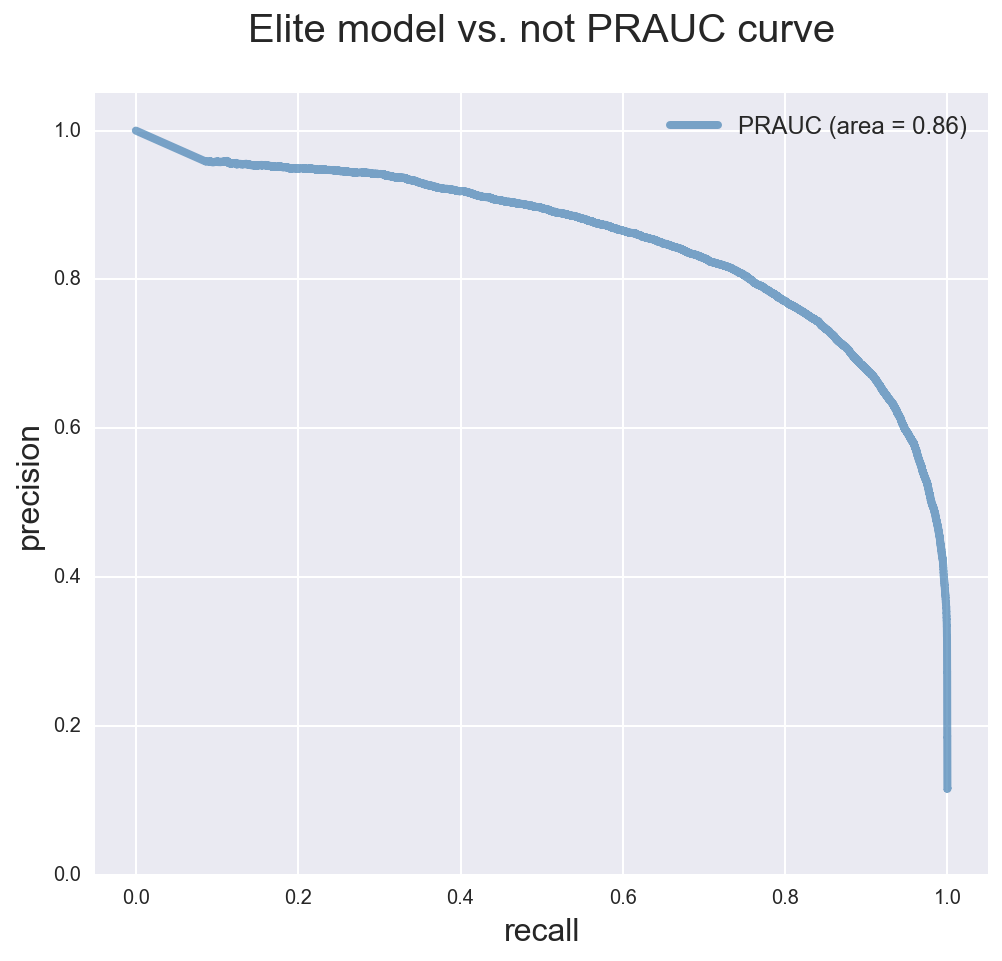

In [332]:
plot_roc(logreg,Xen,np.ravel(ye),'Elite model')
plot_prauc(logreg,Xen,np.ravel(ye),'Elite model')

The count columns are the strongest features. This is illustrated by these features having the highest betas in the logistic regression. This is also illustrated by the superior precision, recall, and accuracy scores of the model using the count features. From the model compliment and vote features carry the most weight. This lead me to believe that Yelp places more emphasis on indivuals that carry influence in their networks. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?